# CSE2530 Computational Intelligence
## Assignment 1: Artificial Neural Networks

<div style="background-color:#f1be3e">

_Fill in your group number **from Brightspace**, names, and student numbers._
    
| Group                  | X       |
|------------------------|---------|
| Ignacio Cuñado Barral  | 5716128 |
| Daniel de Dios Allegue | 5722055 |
| Pablo Hendriks Bardaji | 5790069 |
| Alberto Moreno Sanchez | 5688078 |

#### Imports

In [173]:
# You may only use numpy to implement your neural network
# You are not allowed to use scikit-learn, other than for Section 1.6.
# You are also not allowed to use Pytorch, Tensorflow, and similar machine learning frameworks.
# You can make use of any other libraries for miscellaneous functions, e.g. to create the visual aids.

# Put all of your imports in this code block
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # Might not be able to use it. 
import seaborn as sns
import matplotlib.image as mpimg

#### Loading the data

In [8]:
features = np.genfromtxt("data/features.txt", delimiter=",")
targets = np.genfromtxt("data/targets.txt", delimiter=",")
unknown = np.genfromtxt("data/unknown.txt", delimiter=",")

## 1 Questions
### 1.2 Architecture
#### Question 1:

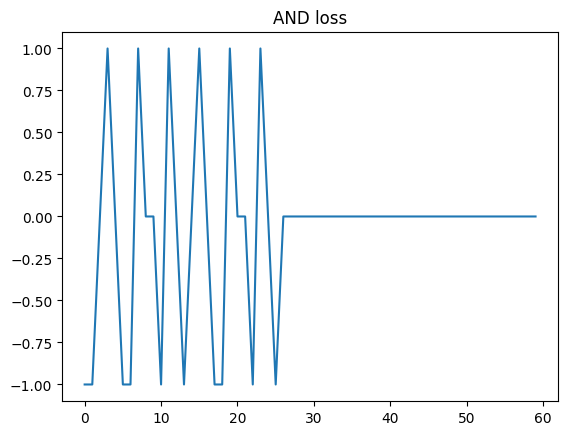

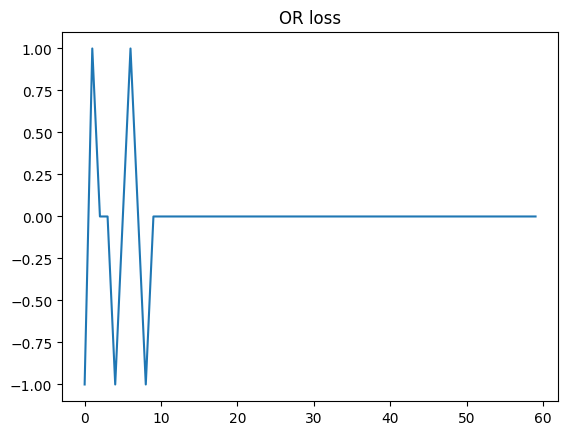

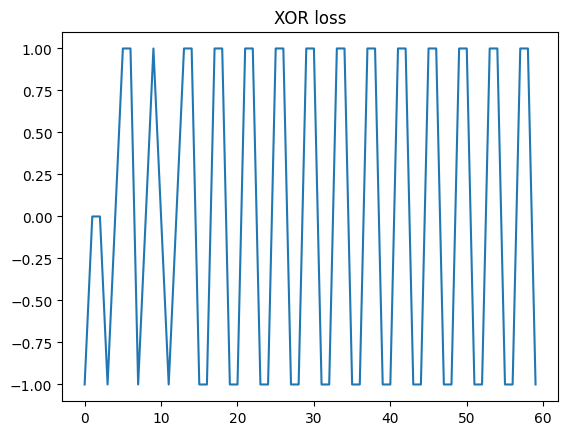

In [76]:
class SinglePerceptron:
    def __init__(self, size):
        # Intialize random weights and bias
        self.weights = np.random.rand(size)
        self.bias = np.random.rand(1)

    def forward(self, inputs):
        return np.dot(inputs, self.weights) + self.bias

    def activation(self, x):
        # ReLU
        return 1 if x >= 0 else 0

    def predict(self, inputs):
        return self.activation(self.forward(inputs))

    def train(self, X, y, epochs, lr):
        error_per_epoch = []
        for _ in range(epochs):
            for i in range(X.shape[0]):
                prediction = self.predict(X[i])
                error = y[i] - prediction
                error_per_epoch.append(error)
                self.weights += lr * error * X[i]
                self.bias += lr * error
        return error_per_epoch

# Train the perceptron of the logic gates
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_and = np.array([0, 0, 0, 1])
y_or = np.array([0, 1, 1, 1])
y_xor = np.array([0, 1, 1, 0])

perceptron = SinglePerceptron(2)
errors_and = perceptron.train(X, y_and, 15, 1)
perceptron = SinglePerceptron(2)
errors_or = perceptron.train(X, y_or, 15, 1)
perceptron = SinglePerceptron(2)
errors_xor = perceptron.train(X, y_xor, 15, 1)

plt.plot(errors_and, label='AND')
plt.title('AND loss')
plt.show()
plt.plot(errors_or, label='OR')
plt.title('OR loss')
plt.show()
plt.plot(errors_xor, label='XOR')
plt.title('XOR loss')
plt.show()

<div style="background-color:#f1be3e">

_As we can see in the loss plots, our single perceptron in able to learn the OR and AND logic functions, since after certain epochs the loss stabilizes at 0.0. On the other hand, our simple architecture is not able to learn the XOR logic gate, and the error never converges to 0. _

#### Question 2

<div style="background-color:#f1be3e">

We need 10 input neurons, each representing 1 feature of the input data

#### Question 3

<div style="background-color:#f1be3e">

Since there are 7 possible classes, we need 7 output neurons.

#### Question 4

<div style="background-color:#f1be3e">

Our initial guess is that we need two hidden layers. Data should not be too complex and it should not be too hard for the ANN to predict the classes. In case we are proven wrong later, and data is more complex than what we initially thought, we will need to increase the number of hidden layers and neurons. There are a few rules of thumb to calculate the number of neurons, but we believe between 12 and 9 neurons per hidden layer should be enough.

#### Question 5

<div style="background-color:#f1be3e">

Since this is multi-class classification problem, the output will be a 7-vector of probabilities. Hence, we need to output the class with the largest probability. We should use the softmax activation function for the output layer. For neurons in the hidden layers, other activation functions like ReLU are typically used.

#### Question 6

<div style="background-color:#f1be3e">

Please note our diagram contains bias units.
![ANN Diagram](resources/ANN_architecture.png)

### 1.3 Training

When coding a neural network from scratch, it helps to think of a layer as an individual component that can be easily combined with other layers. To help you create a modular implementation of a neural network, we provide you with a template for the implementation along with some explanations.

**Note that using the template below is not mandatory. You may choose to modify this template or implement your own version of the neural network altogether. If the latter, please remove our template from the notebook and ensure that it instead includes a complete, fully functional implementation of your own.**

**Linear (fully connected) layer**

A linear or fully connected layer maps the input data to an output by performing a linear transformation, where each input neuron is connected to every output neuron. The forward pass of a linear layer is computed as $y = wx + b$, where $w$ and $b$ are trainable parameters. The gradients of the loss with respect to $w$ and $b$ are defined using the chain rule:

$$\frac{\partial \mathcal{L}}{\partial w}=\frac{\partial \mathcal{L}}{\partial y} \cdot \frac{\partial y}{\partial w}, \quad \frac{\partial \mathcal{L}}{\partial b}=\frac{\partial \mathcal{L}}{\partial y} \cdot \frac{\partial y}{\partial b}, $$

where $\frac{\partial \mathcal{L}}{\partial y}$ is the upstream gradient i.e., the gradient flowing from deeper layers into the current layer, and the other two terms are the local gradients:

$$
\frac{\partial y}{\partial w}=x, \quad \frac{\partial y}{\partial b}=1.
$$

Since $x$ is needed to compute the gradients, we can store (cache) its value during the forward pass. Finally, we need to return a downstream gradient so that more shallow layers can use it as their upstream gradient. The downstream gradient of a layer is simply its upstream gradient multiplied by the local gradient of its ouput with respect to its input:

$$
\frac{\partial \mathcal{L}}{\partial x}=\frac{\partial \mathcal{L}}{\partial y} \cdot \frac{\partial y}{\partial x}
$$

**Note.** Be aware of how you multiply the arrays, it might be useful to print the shapes of each array and to think about the desired shape of the output.  

In [77]:
class Linear:
    def __init__(self, in_features, out_features, initialization, activation):
        """ Randomly initialize the weights and biases.

        Args:
            in_features: number of input features.
            out_features: number of output features.
        """

        self.weight, self.bias = initialization(in_features, out_features)
        self.activation = activation
        self.cache = None
        # For storing the gradients w.r.t. the weight and the bias
        self.weight_grad = None
        self.bias_grad = None

    def forward(self, x):
        """ Perform the forward pass of a linear layer. 
        Store (cache) the input, so it can be used in the backward pass.

        Args:
            x: input of a linear layer.

        Returns: 
            y: output of a linear layer. 
        """
        self.cache = x
        z = x @ self.weight + self.bias
        return self.activation.forward(z)
    
    def backward(self, dupstream):
        """ Perform the backward pass of a linear layer.  

        Args:
            dupstream: upstream gradient. 

        Returns:
            dx: downstream gradient.
        """
       
        dupstream = self.activation.backward(dupstream)
        self.weight_grad = self.cache.T @ dupstream
        self.bias_grad = np.sum(dupstream, axis=0, keepdims=True)
        return dupstream @ self.weight.T

In [78]:
def uniform_initialization(f_in, f_out):
    weight = np.random.rand(f_in, f_out)
    bias = np.random.rand(1, f_out)
    return weight, bias

def normal_initialization(f_in, f_out):
    weight = np.random.randn(f_in, f_out)
    bias = np.random.randn(1, f_out)
    return weight,bias

def exp_initialization(f_in, f_out):
    weight = np.random.exponential(2, (f_in, f_out))
    bias = np.random.exponential(2, (1, f_out))
    return weight,bias

def he_initialization(f_in, f_out):
    weight = np.random.randn(f_in, f_out) * np.sqrt(2 / f_in)
    bias = np.zeros((1, f_out))
    return weight, bias

def constant_initialization(f_in, f_out):
    constant = np.random.randint(1, 10)
    weight = np.full((f_in, f_out), constant)
    bias = np.full((1, f_out), constant) 
    return weight, bias

**Activation functions**

You alo need to implement an activation function suitable for the task at hand.

Think about how to perform the backward pass i.e., what is the local gradient and what the downstream gradient should be. Do not forget to take the upstream gradient into account.

In [140]:
class ReLU:
    def __init__(self):
        self.cache = None
    
    def forward(self, x):
        """ Perform a forward pass of your activation function.
        Store (cache) the output, so it can be used in the backward pass.

        Args:
            x: input to the activation function. 

        Returns:
            y: output of the activation function.
        """
        
        self.cache = x
        return np.maximum(0, x)
    
    def backward(self, dupstream): 
        """ Perform a backward pass of the activation function. 
        Make sure you do not modify the original dupstream.

        Args:
            dupstream: upstream gradient. 

        Returns:
            dx: downstream gradient.
        """
        
        return dupstream * (self.cache > 0)

In [141]:
class SoftMax:
    def __init__(self):
        self.cache = None
    
    def forward(self, x):
        """ Perform a forward pass of your activation function.
        Store (cache) the output, so it can be used in the backward pass.

        Args:
            x: input to the activation function. 

        Returns:
            y: output of the activation function.
        """
        
        shiftx = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(shiftx)
        softmax = exps / np.sum(exps, axis=1, keepdims=True)
        self.cache = softmax
        return softmax
    
    def backward(self, dupstream): 
        """ Perform a backward pass of the activation function. 
        Make sure you do not modify the original dupstream.

        Args:
            dupstream: upstream gradient. 

        Returns:
            dx: downstream gradient.
        """
        softmax = self.cache
        return dupstream * softmax * (1 - softmax)

**Network** 

Now that you have implemented a `Linear` layer and an activation function, you can combine them in different ways and have the `Network` class perform forward and backward passes through all layer of the network in the specified order.

Additionally, you should make the `Network` class update all the trainable parameters of the network in `optimizer_step`.

In [142]:
class Network:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        """ Perform a forward pass over the entire network.

        Args:
            x: input data. 

        Returns:
            y: predictions.
        """
        
        y = x
        for layer in self.layers:
            y = layer.forward(y)
        return y
    
    def backward(self, dupstream):
        """ Perform a backward pass over the entire network.

        Args:
            dupstream: upstream gradient. 

        Returns:
            dx: downstream gradient.
        """
        
        dx = dupstream
        for layer in reversed(self.layers):
            dx = layer.backward(dx)
        return dx
    
    def optimizer_step(self, lr):
        """ Update the weight and bias parameters of each layer.

        Args:
            lr: learning rate.
        """
        
        for layer in self.layers:
            layer.weight = layer.weight - lr * layer.weight_grad
            layer.bias = layer.bias - lr * layer.bias_grad

**Loss function**

You also need to implement a loss function that will measure how well your neural network performs at the task.

In [143]:
def loss(y_true, y_pred):
    """ Computes the value of the loss function and its gradient.  

    Args:
        y_true: ground truth labels.
        y_pred: predicted labels.

    Returns:
        loss: value of the loss. 
        grad: gradient of loss with respect to the predictions. 
    """

    epsilon = 1e-15
    
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    loss = -np.sum(y_true * np.log(y_pred + epsilon)) / y_true.shape[0] 
    grad = y_pred - y_true

    return loss, grad

**Encoding**

We have defined functions to encode and decode vectors into one-hot format.

In [144]:
def one_hot_encode(y, num_classes):
    """Converts a vector of labels to one-hot encoded format.

    Args:
        y: Array of labels, shape (num_samples,).
        num_classes: Number of classes.

    Returns:
        One-hot encoded labels, shape (num_samples, num_classes).
    """
    y = y.astype(int) - 1

    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

def decode(y):
    """Decodes the output of the neural net into the labels

    Args:
        y: Array of one-hot-encoded labels, shape (num_samples,7).

    Returns:
        Labels, shape (num_samples).
    """
    
    return np.argmax(y, axis=1) + 1

**Training loop**

Finally, define a training loop in which for each optimizer step you:

1. Obtain the predictions by performing a forward pass of the network;

2. Compute the loss and its gradient by comparing the predictions with the ground truth according to the selected criterion;

3. Perform a backward pass of the network;

4. Update all parameters of the network i.e, take an optimizer step.

In [145]:
def train(net, inputs, labels, val_inputs, val_labels, criterion, lr, epochs):
    """Trains the neural network.

    Args:
        net: network or model. 
        inputs: input data.
        labels: labels. 
        criterion: loss function.
        lr: learning rate.
        epochs: number of epochs (training steps)

    Returns:
        losses: a list containing the loss at every optimizer step. 
        accuracies: a list containing the accuracy at every optimizer step. 
    """
    
    accuracies = []
    losses = []
    val_accuracies = []

    for _ in range(epochs):
        epoch_accuracy = 0
        epoch_loss = 0
        for i in range(len(inputs)):
            predictions = net.forward(inputs[i])
            batch_labels = labels[i]
            loss, grad = criterion(batch_labels, predictions)
            net.backward(grad)
            net.optimizer_step(lr)
            
            
            epoch_loss += loss
            epoch_accuracy += np.sum(decode(predictions) == decode(batch_labels)) / len(decode(predictions))
            
        # Compute validation accuracy once per epoch
        val_predictions = net.forward(val_inputs)
        val_accuracy = np.sum(decode(val_predictions) == decode(val_labels)) / len(decode(val_predictions))
        
        
        val_accuracies.append(val_accuracy)
        accuracies.append(epoch_accuracy / inputs.shape[0])
        losses.append(epoch_loss / inputs.shape[0])
    return losses, accuracies, val_accuracies

In [146]:
def predict(net, input):
    return np.argmax(net.forward(input), axis=1) + 1

#### Question 7

In [147]:
def create_batches(features, targets, batch_length):

    num_samples = len(features)
    remaining = num_samples % batch_length
    
    features = features[:-remaining]
    targets = targets[:-remaining]

    num_batches = num_samples // batch_length

    batches_features = [features[i * batch_length: (i + 1) * batch_length] for i in range(num_batches)]
    batches_targets = [targets[i * batch_length: (i + 1) * batch_length] for i in range(num_batches)]

    return batches_features, batches_targets

In [148]:
def divide_data(features, targets, batch_size, validation_frac=0.15, test_frac = 0.15):
    combined_data = np.column_stack((features, targets))
    np.random.shuffle(combined_data)
    features = combined_data[:, :-1]
    targets = combined_data[:, -1]
    
    split_index_1 = int(features.shape[0] * (1 - test_frac - validation_frac))
    split_index_2 = int((1 - test_frac) * features.shape[0])
    X_train = features[:split_index_1]
    X_val = features[split_index_1:split_index_2]
    X_test = features[split_index_2:]
    y_train = targets[:split_index_1]
    y_val = targets[split_index_1:split_index_2]
    y_test = targets[split_index_2:]
    
    y_train = one_hot_encode(y_train, 7)
    y_val = one_hot_encode(y_val, 7)
    
    X_train, y_train = create_batches(X_train, y_train, batch_size)
    
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)

In [149]:
X_train, y_train, X_val, y_val, X_test, y_test = divide_data(features, targets, 64, 0.15, 0.15)

In [150]:
X_train.shape

(85, 64, 10)

In [151]:
y_train.shape

(85, 64, 7)

In [152]:
X_test.shape

(1179, 10)

In [153]:
y_test.shape

(1179,)

In [154]:
y_val.shape

(1178, 7)

<div style="background-color:#f1be3e">

Since we want unbiased estimates and good performing predictions, we will make a 70/30 split. A 70/30 split provides a reasonable balance between sufficient train and test/validation data, preventing overfitting whilst giving us enough detail about the performance of the model. We have decided to randomly shuffle the data to ensure reproducibility and to make sure the order does not affect performance. We are aware, however, that splitting data using a fixed ratio is not always the best answer possible as there does not exist a one-size-fits-all split, better approaches would include cross validation.

#### Question 8

In [159]:
def performance(performance_network: Network, performance_X_test, performance_Y_test):    
    # Make predictions of test data
    performance_predictions = predict(performance_network, performance_X_test)
    # Compare predictions with actual labels and return that
    return np.sum(performance_predictions == performance_Y_test) / len(performance_Y_test)

In [157]:
def calc_accuracy(predictions, truth):
    assert(predictions.shape == truth.shape)
    return np.sum(predictions == truth) / len(truth)

<div style="background-color:#f1be3e">

We will use the accuracy metric to evaluate the performance of the network. This is because we are dealing with a classification problem and we want to know how many of the predictions were correct.

#### Question 9

<div style="background-color:#f1be3e">

We will stop training after a certain number of iterations (epochs), or after the error stops decreasing or the error is below a certain threshold. We have inserted an epoch parameter in the ```train``` function above in order to easily change the amount of training steps. The number of epochs along with the learning rate will be tweaked in the optimisation part of the assignment. Too many epochs can result to overfitting and long training times, whilst too few epochs may lead to underfitting, where the model fails to capture the underlying patterns in the data. Finding the right balance is important if we want to achieve the optimal performance of the model. That is why we will regularly monitor this process.

#### Question 10

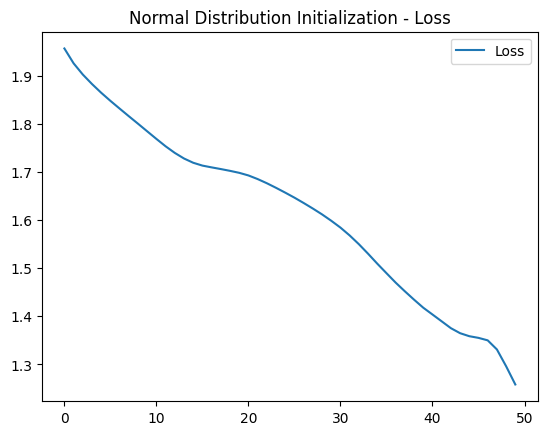

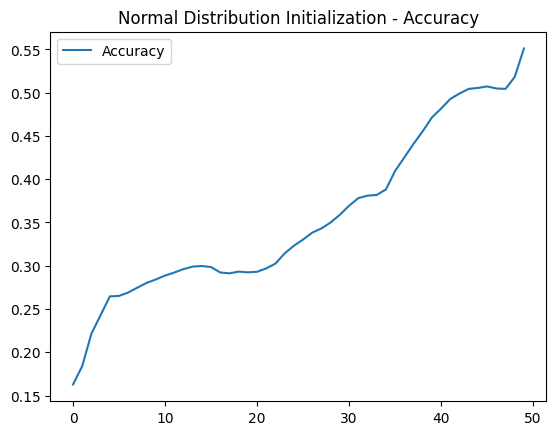

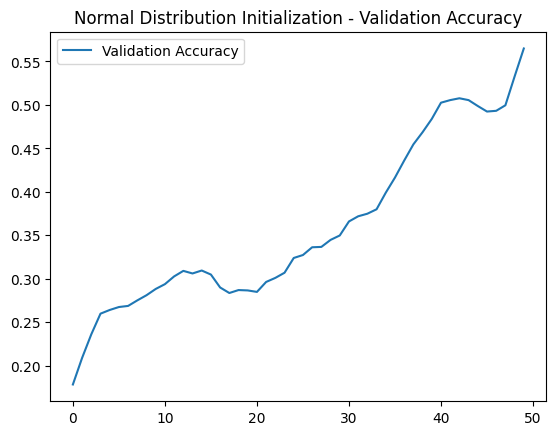

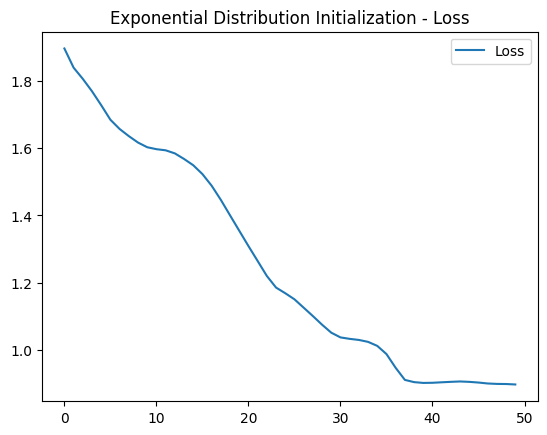

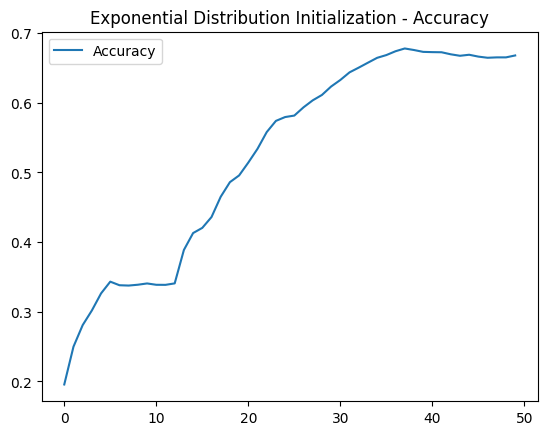

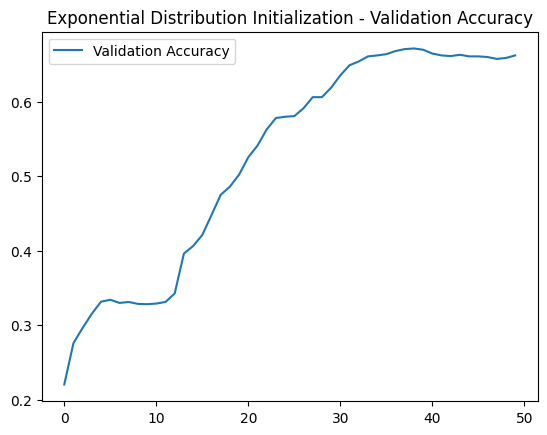

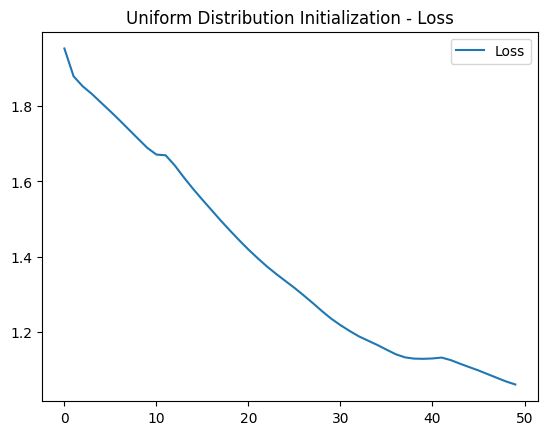

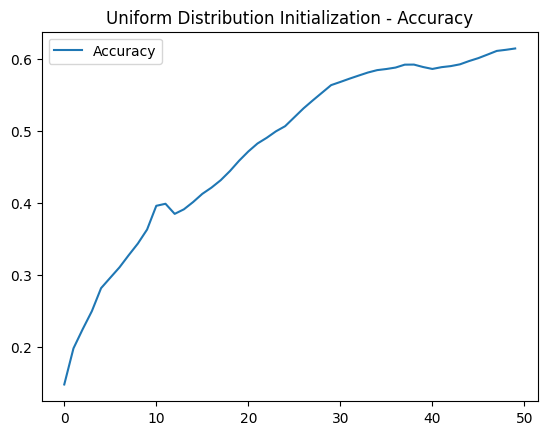

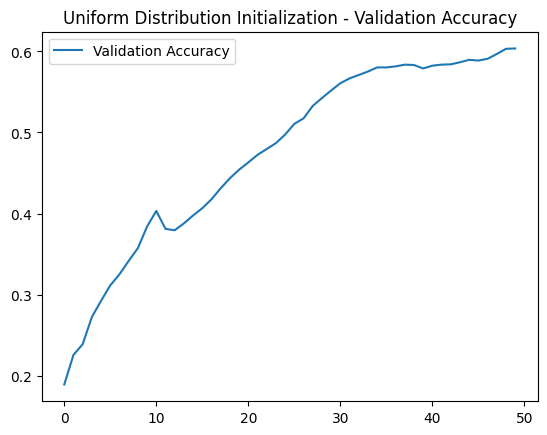

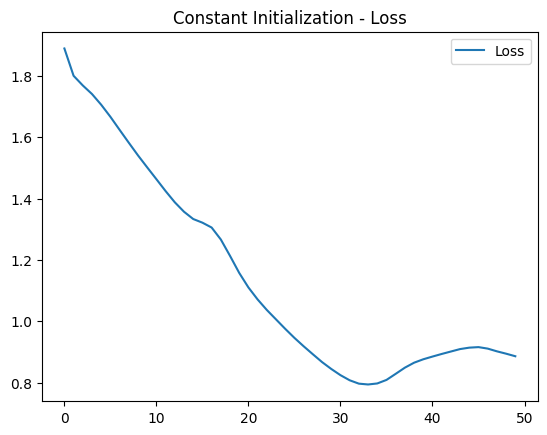

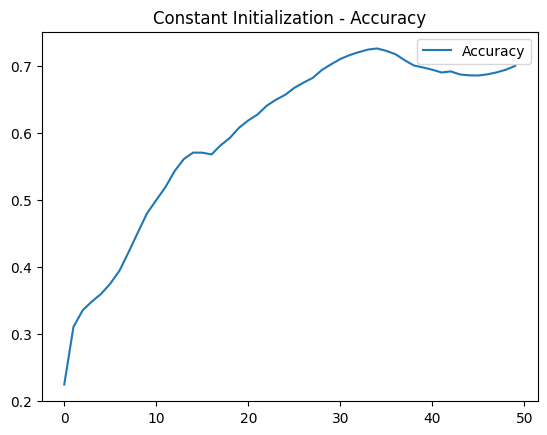

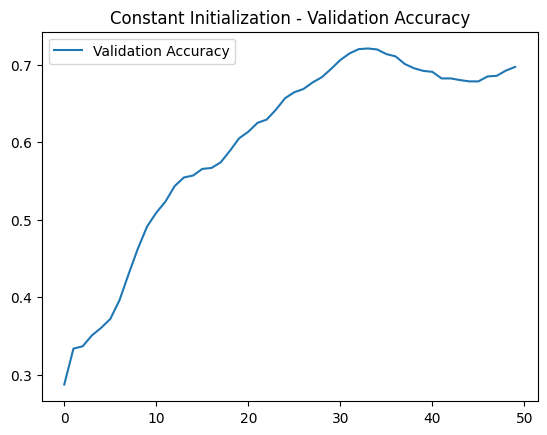

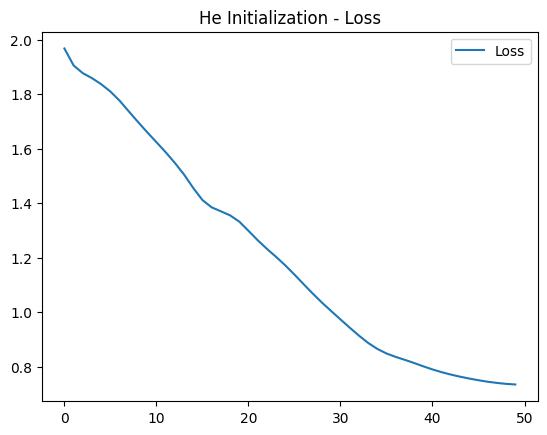

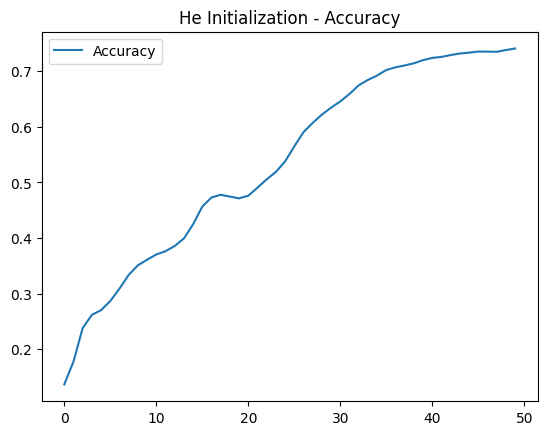

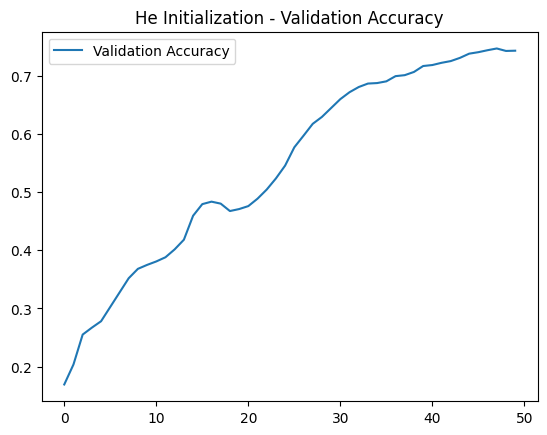

In [139]:
epochs = 50

relu = ReLU()
softmax = SoftMax()
initialization_functions = [(normal_initialization, 'Normal Distribution'), (exp_initialization, 'Exponential Distribution'), (uniform_initialization, 'Uniform Distribution'), (constant_initialization, 'Constant'), (he_initialization, 'He')]

for init, name in initialization_functions:
    loss_arr, accuracy_arr, val_accuracies_arr = [], [], []
    
    for _ in range(2): 
        layers = [Linear(10, 8, he_initialization, relu), Linear(8, 8, he_initialization, relu), Linear(8, 8, he_initialization, relu), Linear(8, 7, he_initialization, softmax)]
        network = Network(layers)
        losses, accuracies, val_accuracies = train(network, X_train, y_train, X_val, y_val, loss, 0.001, epochs)
        loss_arr.append(losses)
        accuracy_arr.append(accuracies)
        val_accuracies_arr.append(val_accuracies)
        
    calculated_loss = np.mean(loss_arr, axis=0)
    calculated_accuracy = np.mean(accuracy_arr, axis=0)
    calculated_val_accuracy = np.mean(val_accuracies_arr, axis=0)
        
    # Plot Loss
    plt.figure()
    plt.plot(calculated_loss, label='Loss')
    plt.title(name + " Initialization - Loss")
    plt.legend()

    # Plot Accuracy
    plt.figure()
    plt.plot(calculated_accuracy, label='Accuracy')
    plt.title(name + " Initialization - Accuracy")
    plt.legend()
    
    #Plot Validation Accuracy
    plt.figure()
    plt.plot(calculated_val_accuracy, label='Validation Accuracy')
    plt.title(name + " Initialization - Validation Accuracy")
    plt.legend()

plt.show()

<div style="background-color:#f1be3e">

We have created a few initialization functions which can be passed into the ```Linear``` class constructor to modify how weight and bias parameters are initialized. It can be clearly seen that the He intialization is the best ones in terms of loss and accuracy (both in train and validation). Uniform initialization has shown the second best results throughout all of our tests. Constant initialization is not good, and it seems like the network does not learn anything. Exponential initialization is also not good, as there is no overall improvement in loss or accuracy. Normal shows the same results.

### 1.4 Optimization

#### Question 11

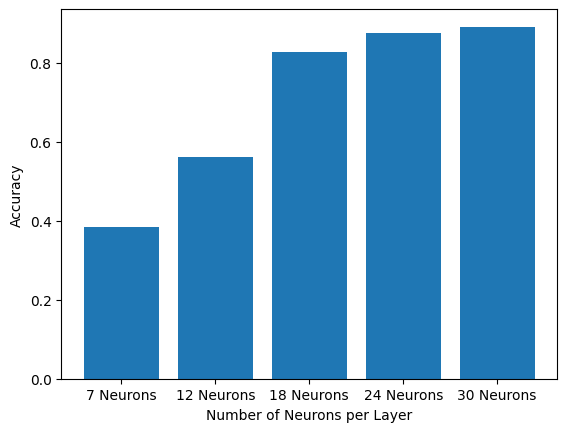

In [160]:
# We will analyze 7, 12, 18, 24, 30 neurons in each hidden layer. We believe this will be a good representative of the given range.

# Activation function
init_funct = he_initialization

# As we want to reduce the effect of random initialization in the results, we will perform all these operations 10 times to later evaluate the average of them.
optimization_performances = {'7 Neurons': 0.0, '12 Neurons': 0.0, '18 Neurons': 0.0, '24 Neurons': 0.0, '30 Neurons': 0.0}
optimization_epochs = 10

for epoch in range(optimization_epochs):
    # Create the layers for each Network
    layers_7 = [Linear(10, 7, init_funct, relu), Linear(7, 7, init_funct, relu), Linear(7, 7, init_funct, relu), Linear(7, 7, init_funct, relu), Linear(7, 7, init_funct, softmax)]
    layers_12 = [Linear(10, 12, init_funct, relu), Linear(12, 12, init_funct, relu), Linear(12, 12, init_funct, relu), Linear(12, 12, init_funct, relu), Linear(12, 7, init_funct, softmax)]
    layers_18 = [Linear(10, 18, init_funct, relu), Linear(18, 18, init_funct, relu), Linear(18, 18, init_funct, relu), Linear(18, 18, init_funct, relu), Linear(18, 7, init_funct, softmax)]
    layers_24 = [Linear(10, 24, init_funct, relu), Linear(24, 24, init_funct, relu), Linear(24, 24, init_funct, relu), Linear(24, 24, init_funct, relu), Linear(24, 7, init_funct, softmax)]
    layers_30 = [Linear(10, 30, init_funct, relu), Linear(30, 30, init_funct, relu), Linear(30, 30, init_funct, relu), Linear(30, 30, init_funct, relu), Linear(30, 7, init_funct, softmax)]
    
    # Create the networks
    network_7_hidden_layers = Network(layers_7)
    network_12_hidden_layers = Network(layers_12)
    network_18_hidden_layers = Network(layers_18)
    network_24_hidden_layers = Network(layers_24)
    network_30_hidden_layers = Network(layers_30)
    
    # Add all networks to array for convenience
    networks = [('7 Neurons', network_7_hidden_layers),
                ('12 Neurons', network_12_hidden_layers),
                ('18 Neurons', network_18_hidden_layers), 
                ('24 Neurons', network_24_hidden_layers),
                ('30 Neurons', network_30_hidden_layers)]

    # Evaluate each networks performance and store them for future analysis
    for opt_name, opt_network in networks:
        # Train to get losses and accuracies
        opt_loss, opt_acc, val_acc = train(opt_network, X_train, y_train, X_val, y_val, loss, 0.001, 50)\
        # Evaluate network in test set
        perf = performance(opt_network, X_test, y_test)
        # Save result and divide by number of times we run the 
        optimization_performances[opt_name] += perf / optimization_epochs
        
# Plot the calculated performances 
plt.bar(optimization_performances.keys(), optimization_performances.values())
plt.xlabel('Number of Neurons per Layer')
plt.ylabel('Accuracy')
plt.show()   

<div style="background-color:#f1be3e">

_As we see when choosing the number of layers, we need to be cautious. 
A naive approach could be to use a big number of hidden nodes per layer, but as we can see, it is not the best idea as we are overfitting the train data. More neurons per layer results in the network being able to learn more complex decision boundary (Universal Approximation Theorem), but also results in more network complexity, higher training times...
We also see that using a very small number gives suboptimal performance as we are underfitting the data, we are not able to capture enough of the underlying features.
In this case we see that 18-24 neurons gives the best performance, therefore, a sensible choice will be anything close to it._


#### Question 12 - Pick Best Architecture


Performance of the final architecture (on the test set): 0.9024597116200169


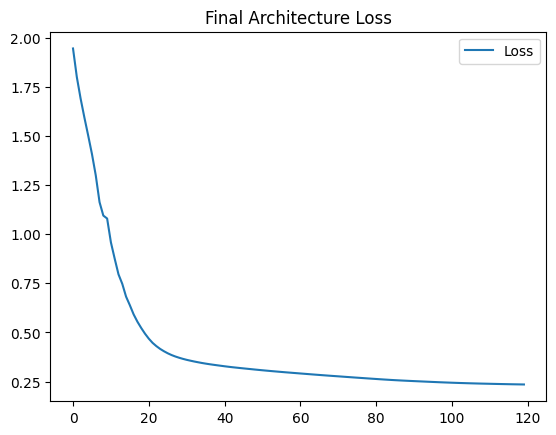

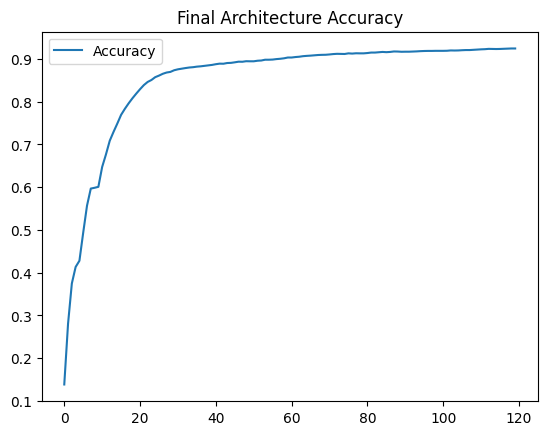

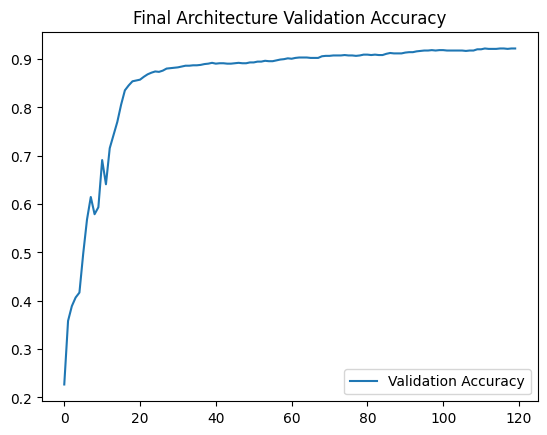

In [163]:
layers_final = [Linear(10, 24, init_funct, relu), Linear(24, 24, init_funct, relu), Linear(24, 24, init_funct, relu), Linear(24, 7, init_funct, softmax)]

network_final = Network(layers_final)

final_loss, final_acc, val_acc = train(network_final, X_train, y_train, X_val, y_val, loss, 0.001, 120)
perf = performance(network_final, X_test, y_test)

# Plot loss
plt.figure()
plt.plot(final_loss, label='Loss')
plt.title("Final Architecture Loss")
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(final_acc, label='Accuracy')
plt.title("Final Architecture Accuracy")
plt.legend()

# Plot validation accuracy
plt.figure()
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Final Architecture Validation Accuracy")
plt.legend()

print(f'Performance of the final architecture (on the test set): {perf}')

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

### 1.5 Evaluation

#### Question 13

In [164]:
predictions_test = predict(network_final, X_test)
accuracy_test = calc_accuracy(predictions_test, y_test)

print(f"Accuracy on the Test Set: {accuracy_test * 100:.2f}%")

Accuracy on the Test Set: 90.25%


<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

#### Question 14

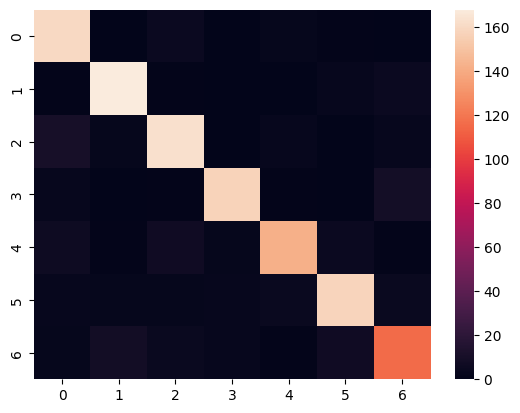

In [166]:
# Plot confusion matrix on the test set

cm = confusion_matrix(y_test, predictions_test)
sns.heatmap(cm, annot=False, annot_kws={"size": 6})
plt.show()

(Note: The labels in the matrix are shifted by 1. In our explanation we will refer to the labels in the matrix, but whenever we refer to class x, we actually consider class x + 1 in the dataset) In our current confusion matrix, darker colour suggests a larger number of matches. Therefore, we can conclude that our model is performing well since the diagonal has a larger number of matches. In a model with 100% accuracy, we should see no dark spots outside the diagonal, but this is not our case. We can see a few 'hotspots'. More specifically, we can see that the model is struggling to differentiate between class 0 and class 1-3. We can also spot a similar case with class 6 and classes 1-3. 

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

#### Question 15 - Submission

In [171]:
preds = predict(network_final, unknown)
# Save predictions in a single line, separated by commas
preds = ','.join(map(str, preds))
np.savetxt('65_classes.txt', [preds], fmt='%s')

<div style="background-color:#f1be3e">

_Our current score on the Autograder is 10/20._

### 1.6 Scikit-learn

#### Question 16

In [36]:
best_params_from_sklearn = {
    'activation': 'relu',
    'alpha': 0.01,
    'batch_size': 'auto',
    'early_stopping': True,
    'hidden_layer_sizes': [30],
    'learning_rate': 0.001,
    'max_iter': 120,
    'n_iter_no_change': 10,
    'random_state': 42,
    'solver': 'adam',
    'tol': 0.0001,
    'validation_fraction' : 0.12749999999999997 
}

<div style="background-color:#f1be3e">

The selected hyperparameters from sklearn are similar to the hyperparameters chosen by us during our optimization. More specifically, the number of epochs chosen was the same (120), and the number of neurons in the hidden layer was set to 30 instead of 24. Furthermore, the learning rate was also set to 0.001. The activation function for the hidden layer was also set to ReLU. However, the main difference is that the number of layers was chosen to be a single one, while we decided to go with 2 hidden layers. In terms of training, our network was a lot less stable than their implementation. Their loss/accuracy curves followed a much more stable pattern, while ours were a lot more erratic. This could be due to the fact that we did not use the same optimizer as they did. This could be potentially due to our optimizer, which was a simple gradient descent procedure. 

#### Question 17

Performance of the scikit architecture (on the test set): 0.8939779474130619


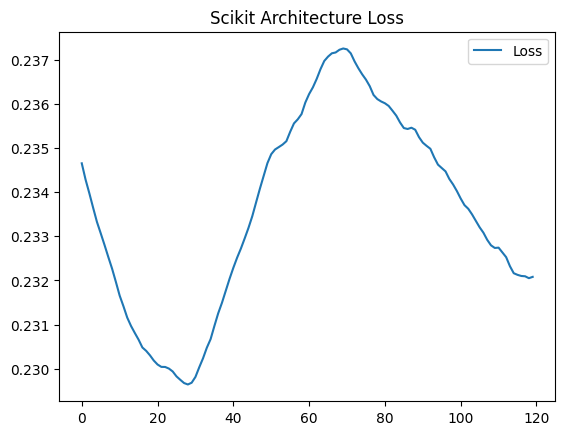

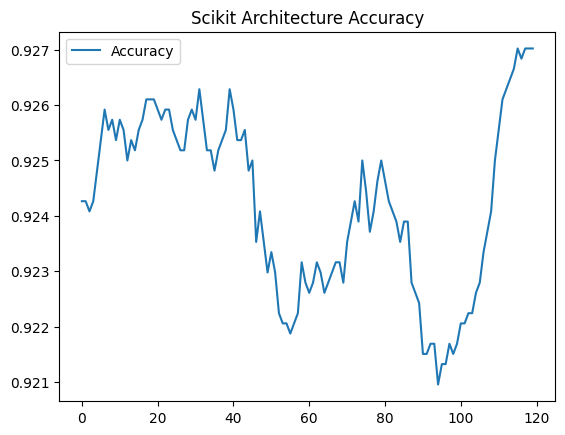

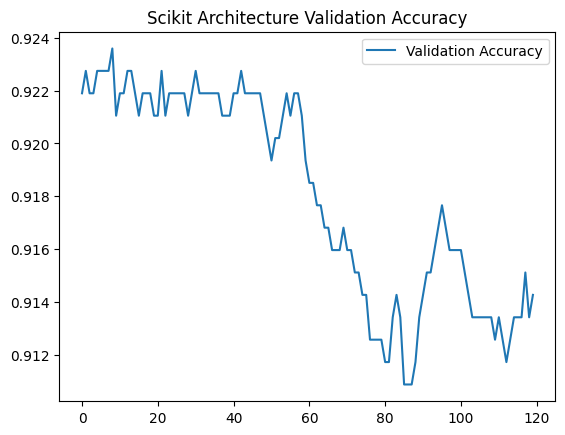

In [165]:
# Note: Chosen params are below Q16. 

layers_scikit = [Linear(10, 30, init_funct, relu), Linear(30, 30, init_funct, relu), Linear(30, 7, init_funct, softmax)]

network_scikit = Network(layers_final)

scikit_loss, scikit_acc, scikit_val = train(network_final, X_train, y_train, X_val, y_val, loss, 0.001, 120)
perf_scikit = performance(network_final, X_test, y_test)

# Plot loss
plt.figure()
plt.plot(scikit_loss, label='Loss')
plt.title("Scikit Architecture Loss")
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(scikit_acc, label='Accuracy')
plt.title("Scikit Architecture Accuracy")
plt.legend()

# Plot validation accuracy
plt.figure()
plt.plot(scikit_val, label='Validation Accuracy')
plt.title("Scikit Architecture Validation Accuracy")
plt.legend()

print(f'Performance of the scikit architecture (on the test set): {perf_scikit}')

<div style="background-color:#f1be3e">

In terms of performance, the network chosen by Scikit's grid search performs slightly better (around 2% to 3% better) than the implementation we chose earlier. However, the loss and accuracy curves are not similar to our implementation. These curves are extremely unstable and they have large variance. This is probably due to the fact that we used different optimizers. However, their implementation still yields a slight increase in accuracy on the test set.  

### 1.7 Reflection

#### Question 18

<div style="background-color:#f1be3e">

A harmful misclassification could happen in the case of a model that was trained to determine if a person is fit or not for a loan. If the model was trained on data such as the person's address, it would end up harming those in the lower income areas. Showing a bias against the people from those areas. Discriminating based on somebodies origins, gender or ethnicity are big biases that we have to avoid when training a model of this, or any other, characteristics. On the other hand, if extreme adjustments are done, the model could end up being biased against the people from the higher income areas. This is why it is important to have a balanced dataset which is representative. 

#### Question 19

<div style="background-color:#f1be3e">

Once the harm is done by the model by misclassification it is extremely hard to reverse this damage. We should then redesign our model with representative and diverse training samples as well as ethical guidelines and external oversight. While it's challenging to guarantee complete elimination of biases, continuous monitoring, transparency, and interdisciplinary collaboration are essential to ensure we reduce biases in AI systems.  An alternative is to alter the dataset in such way that it offers are more global and representative summary of the problem. A way to do this is to introduce noise in the dataset in such way that the variations in the input data represent a larger part of the population of the problem. 






### 1.8 Pen and paper

#### Question 20

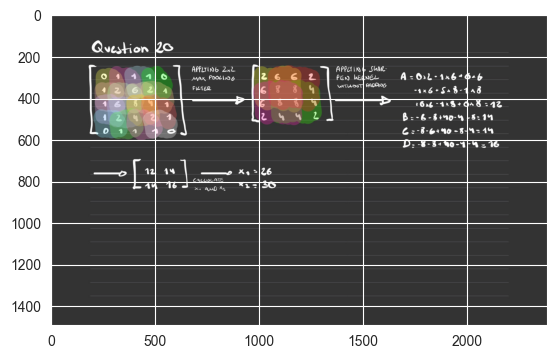

In [174]:
img1 = mpimg.imread('resources/Assignment 1-2.jpg')
imgplot1 = plt.imshow(img1)
plt.show()

#### Question 21

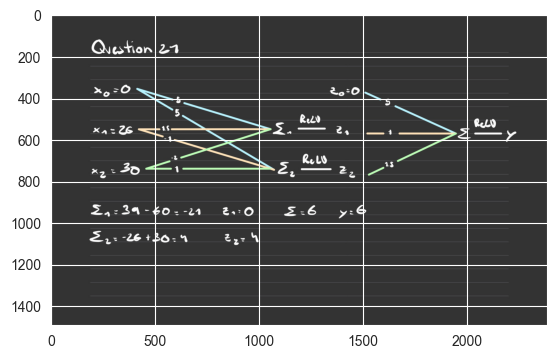

In [175]:
img2 = mpimg.imread('resources/Assignment 1-3.jpg')
imgplot1 = plt.imshow(img2)
plt.show()

### 1.9 Division of work

#### Question 22

<div style="background-color:#f1be3e">


|          Component          | Daniel De Dios | Alberto Moreno | Pablo Hendriks | Ignacio Cuñado |
|-----------------------------|----------------|----------------|----------------|----------------|
| Code (design)               | 0.5            |                |                | 0.5            |
| Code (implementation)       | 0.33           |                | 0.33           | 0.33           |
| Code (validation)           |                | 0.5            | 0.5            |                |
| Experiments (execution)     | 0.33           | 0.33           |                | 0.33           |
| Experiments (analysis)      |                | 0.5            | 0.5            |                |
| Experiments (visualization) |                |                | 0.5            | 0.5            |
| Report (original draft)     | 0.25           | 0.5            |                | 0.25           |
| Report (reviewing, editing) | 0.5            | 0.5            |                |                |

### References

<div style="background-color:#f1be3e">

**If you made use of any non-course resources, cite them below.**
Buhl, N. (2023, October 27). How to mitigate bias in machine Learning Models. https://encord.com/blog/reducing-bias-machine-learning/